# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [6]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = layers.Conv2D(filters=filters, kernel_size=(5,5), strides=(1,1) ,
                      padding='same', activation='relu')(input_layer)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    #onebyone_conv_layer = conv2d_batchnorm(x4,512,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    #x4_p = decoder_block(onebyone_conv_layer, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_12/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_14/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_16/batchnorm/add_1:0", s

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [15]:
learning_rate = 0.0002 # 0.0001 - slow
batch_size = 45 #512/384 => Exhaust resources
num_epochs = 100
num_img_train = 3734
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 83
Validation steps: 27


Epoch 1/100
82/83 [============================>.] - ETA: 2s - loss: 0.9982

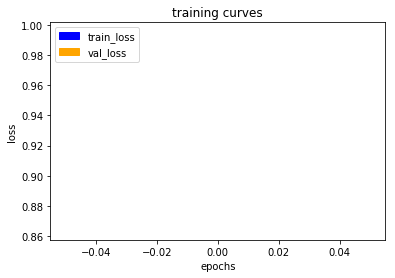

83/83 [==============================] - 186s - loss: 0.9951 - val_loss: 0.8641
Epoch 2/100
82/83 [============================>.] - ETA: 2s - loss: 0.6547

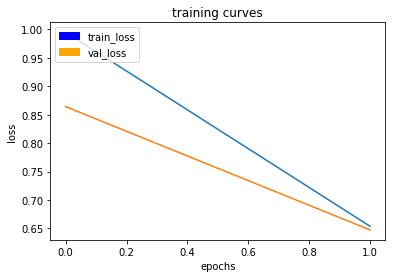

83/83 [==============================] - 185s - loss: 0.6536 - val_loss: 0.6472
Epoch 3/100
82/83 [============================>.] - ETA: 2s - loss: 0.4928

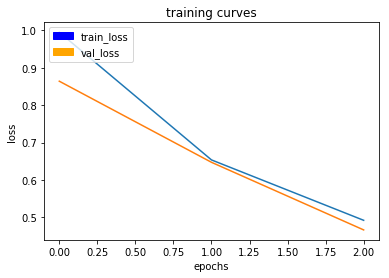

83/83 [==============================] - 184s - loss: 0.4921 - val_loss: 0.4664
Epoch 4/100
82/83 [============================>.] - ETA: 2s - loss: 0.3799

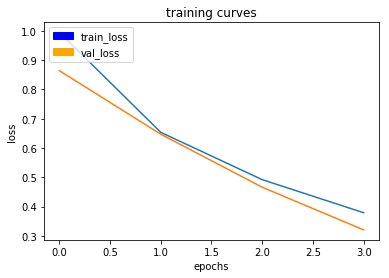

83/83 [==============================] - 185s - loss: 0.3793 - val_loss: 0.3206
Epoch 5/100
82/83 [============================>.] - ETA: 2s - loss: 0.2899

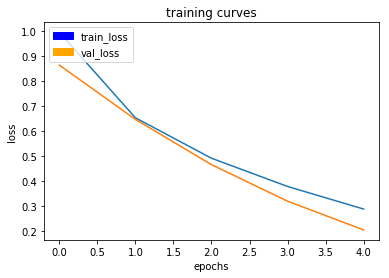

83/83 [==============================] - 184s - loss: 0.2891 - val_loss: 0.2059
Epoch 6/100
82/83 [============================>.] - ETA: 2s - loss: 0.2237

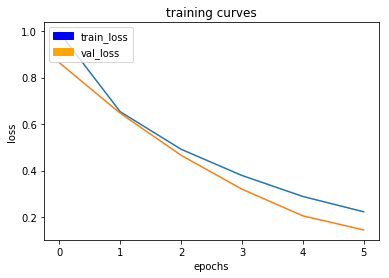

83/83 [==============================] - 185s - loss: 0.2232 - val_loss: 0.1452
Epoch 7/100
82/83 [============================>.] - ETA: 2s - loss: 0.1718

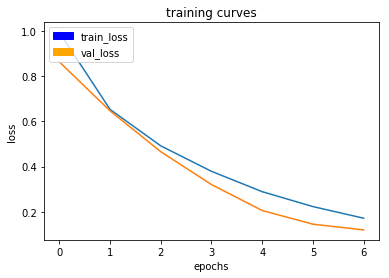

83/83 [==============================] - 183s - loss: 0.1717 - val_loss: 0.1199
Epoch 8/100
82/83 [============================>.] - ETA: 2s - loss: 0.1391

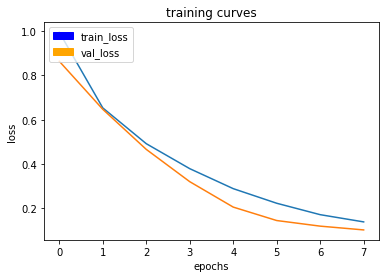

83/83 [==============================] - 185s - loss: 0.1390 - val_loss: 0.1028
Epoch 9/100
82/83 [============================>.] - ETA: 2s - loss: 0.1138

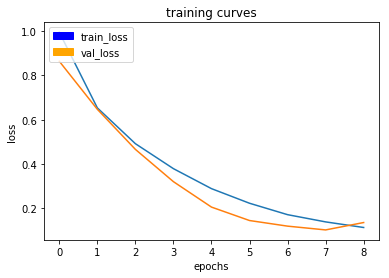

83/83 [==============================] - 184s - loss: 0.1138 - val_loss: 0.1361
Epoch 10/100
82/83 [============================>.] - ETA: 2s - loss: 0.0962

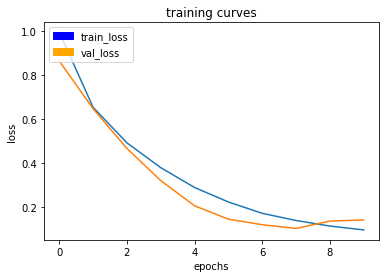

83/83 [==============================] - 184s - loss: 0.0962 - val_loss: 0.1416
Epoch 11/100
82/83 [============================>.] - ETA: 2s - loss: 0.0825

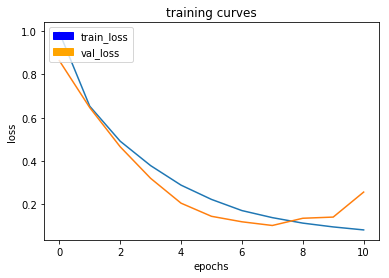

83/83 [==============================] - 185s - loss: 0.0824 - val_loss: 0.2571
Epoch 12/100
82/83 [============================>.] - ETA: 2s - loss: 0.1488

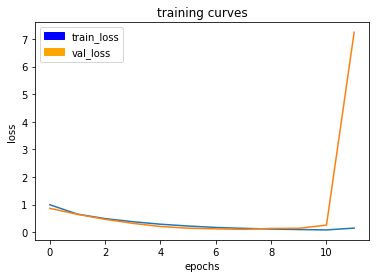

83/83 [==============================] - 185s - loss: 0.1485 - val_loss: 7.2445
Epoch 13/100
82/83 [============================>.] - ETA: 2s - loss: 0.0976

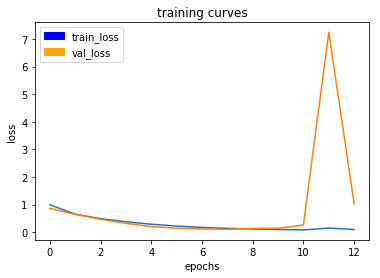

83/83 [==============================] - 184s - loss: 0.0975 - val_loss: 1.0265
Epoch 14/100
82/83 [============================>.] - ETA: 2s - loss: 0.0760

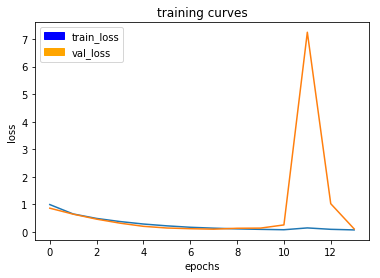

83/83 [==============================] - 185s - loss: 0.0759 - val_loss: 0.1125
Epoch 15/100
82/83 [============================>.] - ETA: 2s - loss: 0.0650

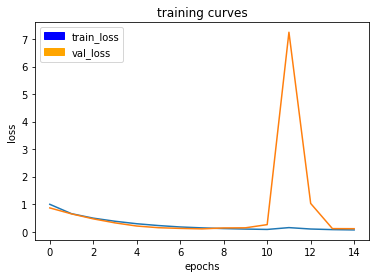

83/83 [==============================] - 185s - loss: 0.0649 - val_loss: 0.1097
Epoch 16/100
82/83 [============================>.] - ETA: 2s - loss: 0.0570

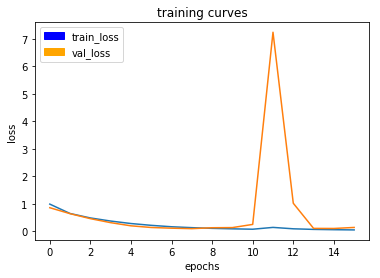

83/83 [==============================] - 185s - loss: 0.0569 - val_loss: 0.1467
Epoch 17/100
82/83 [============================>.] - ETA: 2s - loss: 0.0521

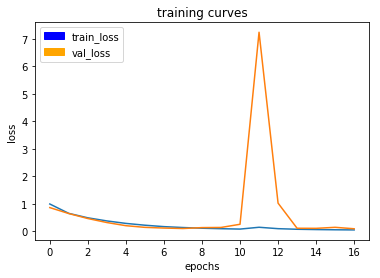

83/83 [==============================] - 185s - loss: 0.0521 - val_loss: 0.0941
Epoch 18/100
82/83 [============================>.] - ETA: 2s - loss: 0.0492

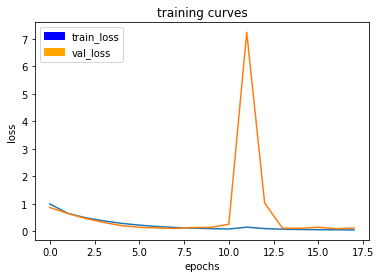

83/83 [==============================] - 185s - loss: 0.0492 - val_loss: 0.1182
Epoch 19/100
82/83 [============================>.] - ETA: 2s - loss: 0.0445

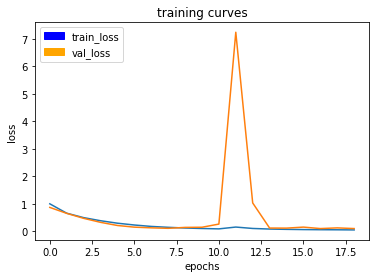

83/83 [==============================] - 185s - loss: 0.0445 - val_loss: 0.0939
Epoch 20/100
82/83 [============================>.] - ETA: 2s - loss: 0.0416

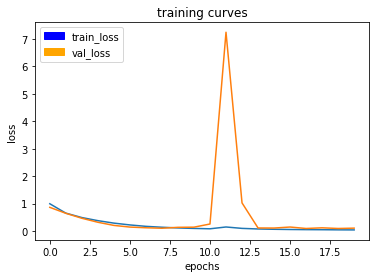

83/83 [==============================] - 185s - loss: 0.0416 - val_loss: 0.1061
Epoch 21/100
82/83 [============================>.] - ETA: 2s - loss: 0.0394

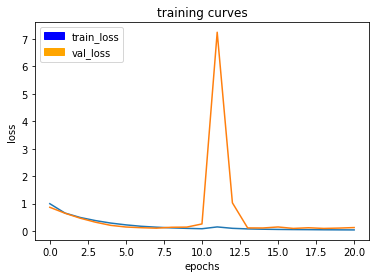

83/83 [==============================] - 185s - loss: 0.0394 - val_loss: 0.1251
Epoch 22/100
82/83 [============================>.] - ETA: 2s - loss: 0.0371

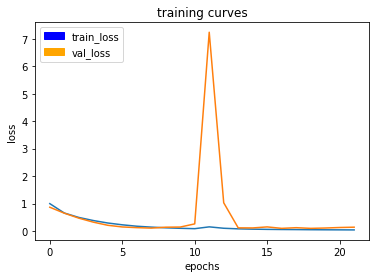

83/83 [==============================] - 186s - loss: 0.0371 - val_loss: 0.1365
Epoch 23/100
82/83 [============================>.] - ETA: 2s - loss: 0.0352

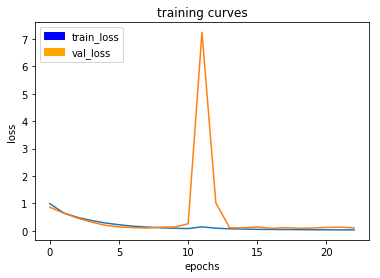

83/83 [==============================] - 185s - loss: 0.0352 - val_loss: 0.1079
Epoch 24/100
82/83 [============================>.] - ETA: 2s - loss: 0.0353

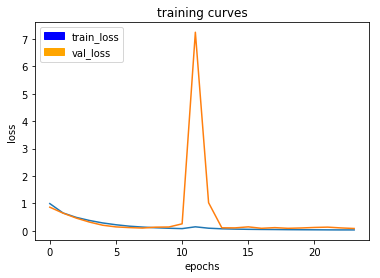

83/83 [==============================] - 185s - loss: 0.0353 - val_loss: 0.0874
Epoch 25/100
82/83 [============================>.] - ETA: 2s - loss: 0.0329

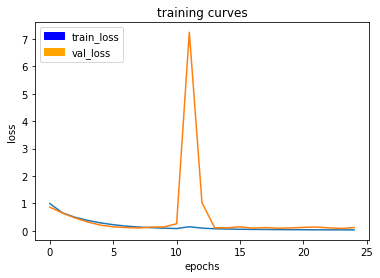

83/83 [==============================] - 185s - loss: 0.0329 - val_loss: 0.1194
Epoch 26/100
82/83 [============================>.] - ETA: 2s - loss: 0.0314

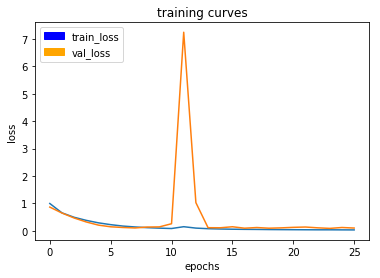

83/83 [==============================] - 185s - loss: 0.0313 - val_loss: 0.0998
Epoch 27/100
82/83 [============================>.] - ETA: 2s - loss: 0.0299

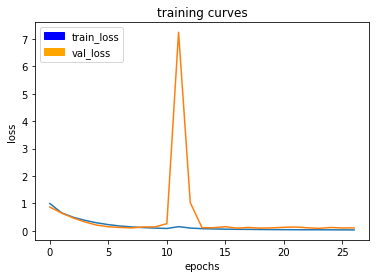

83/83 [==============================] - 184s - loss: 0.0299 - val_loss: 0.1043
Epoch 28/100
82/83 [============================>.] - ETA: 2s - loss: 0.0290

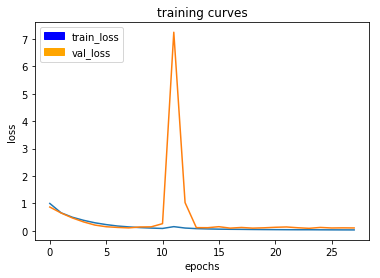

83/83 [==============================] - 185s - loss: 0.0290 - val_loss: 0.1006
Epoch 29/100
82/83 [============================>.] - ETA: 2s - loss: 0.0279

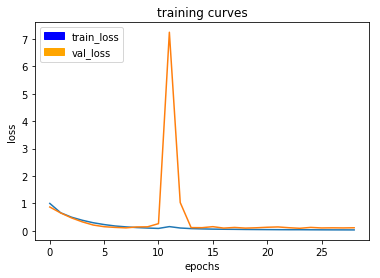

83/83 [==============================] - 185s - loss: 0.0279 - val_loss: 0.1064
Epoch 30/100
82/83 [============================>.] - ETA: 2s - loss: 0.0271

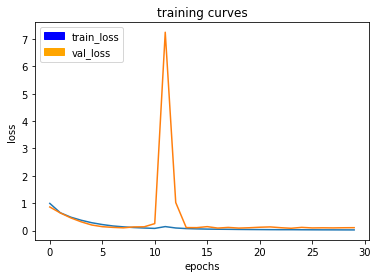

83/83 [==============================] - 185s - loss: 0.0271 - val_loss: 0.1089
Epoch 31/100
82/83 [============================>.] - ETA: 2s - loss: 0.0261

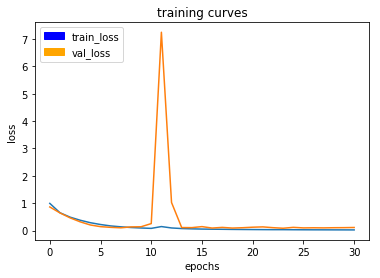

83/83 [==============================] - 185s - loss: 0.0260 - val_loss: 0.1146
Epoch 32/100
82/83 [============================>.] - ETA: 2s - loss: 0.0256

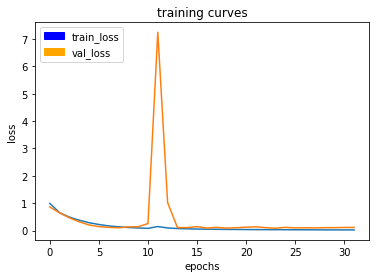

83/83 [==============================] - 185s - loss: 0.0256 - val_loss: 0.1167
Epoch 33/100
82/83 [============================>.] - ETA: 2s - loss: 0.0246

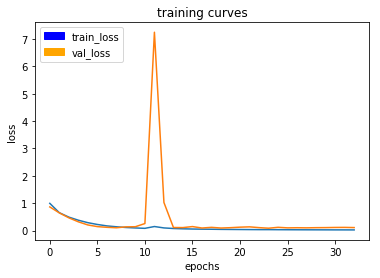

83/83 [==============================] - 185s - loss: 0.0246 - val_loss: 0.1099
Epoch 34/100
82/83 [============================>.] - ETA: 2s - loss: 0.0239

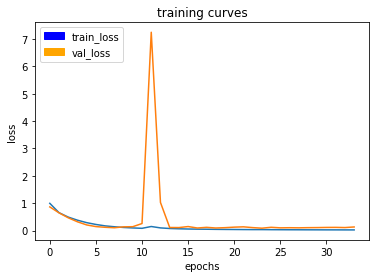

83/83 [==============================] - 186s - loss: 0.0239 - val_loss: 0.1316
Epoch 35/100
82/83 [============================>.] - ETA: 2s - loss: 0.0232

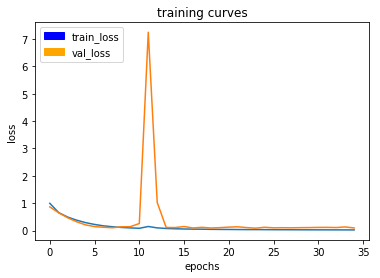

83/83 [==============================] - 185s - loss: 0.0233 - val_loss: 0.0952
Epoch 36/100
82/83 [============================>.] - ETA: 2s - loss: 0.0226

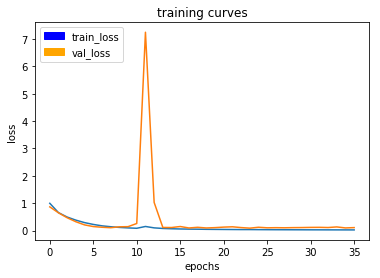

83/83 [==============================] - 185s - loss: 0.0226 - val_loss: 0.1070
Epoch 37/100
82/83 [============================>.] - ETA: 2s - loss: 0.0218

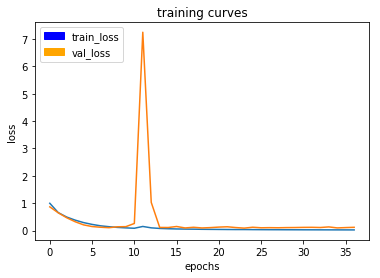

83/83 [==============================] - 185s - loss: 0.0219 - val_loss: 0.1172
Epoch 38/100
82/83 [============================>.] - ETA: 2s - loss: 0.0218

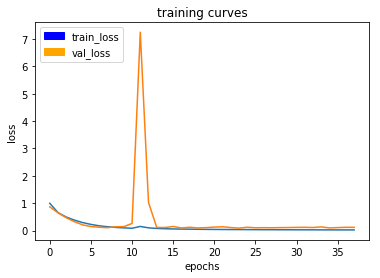

83/83 [==============================] - 184s - loss: 0.0218 - val_loss: 0.1166
Epoch 39/100
82/83 [============================>.] - ETA: 2s - loss: 0.0212

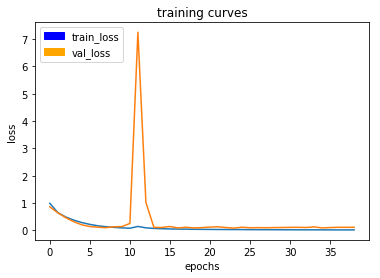

83/83 [==============================] - 185s - loss: 0.0212 - val_loss: 0.1160
Epoch 40/100
82/83 [============================>.] - ETA: 2s - loss: 0.0208

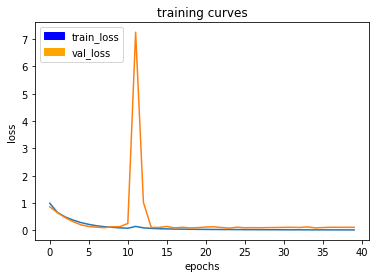

83/83 [==============================] - 185s - loss: 0.0208 - val_loss: 0.1159
Epoch 41/100
82/83 [============================>.] - ETA: 2s - loss: 0.0243

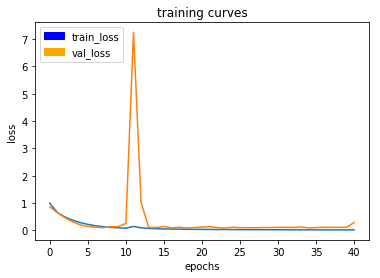

83/83 [==============================] - 185s - loss: 0.0243 - val_loss: 0.2908
Epoch 42/100
82/83 [============================>.] - ETA: 2s - loss: 0.0230

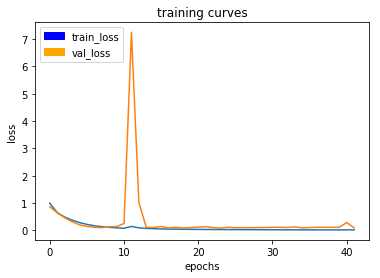

83/83 [==============================] - 185s - loss: 0.0230 - val_loss: 0.0965
Epoch 43/100
82/83 [============================>.] - ETA: 2s - loss: 0.0208

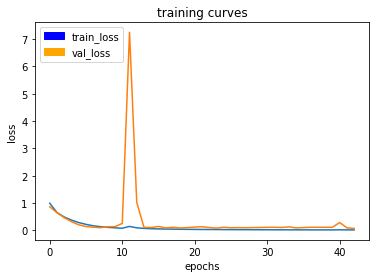

83/83 [==============================] - 185s - loss: 0.0209 - val_loss: 0.0763
Epoch 44/100
82/83 [============================>.] - ETA: 2s - loss: 0.0199

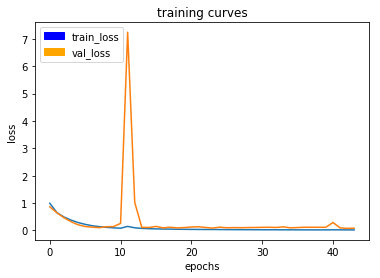

83/83 [==============================] - 185s - loss: 0.0199 - val_loss: 0.0850
Epoch 45/100
82/83 [============================>.] - ETA: 2s - loss: 0.0191

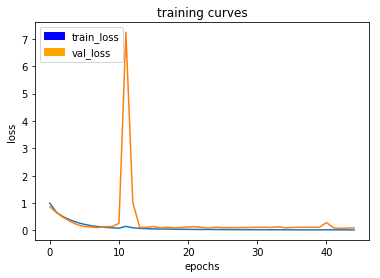

83/83 [==============================] - 185s - loss: 0.0191 - val_loss: 0.0945
Epoch 46/100
82/83 [============================>.] - ETA: 2s - loss: 0.0189

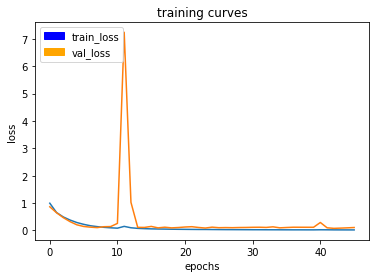

83/83 [==============================] - 185s - loss: 0.0189 - val_loss: 0.1066
Epoch 47/100
82/83 [============================>.] - ETA: 2s - loss: 0.0183

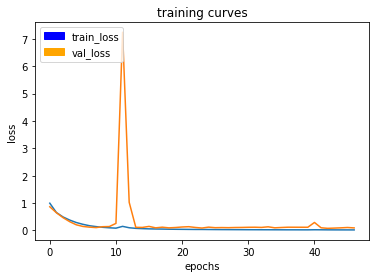

83/83 [==============================] - 185s - loss: 0.0183 - val_loss: 0.0918
Epoch 48/100
82/83 [============================>.] - ETA: 2s - loss: 0.0179

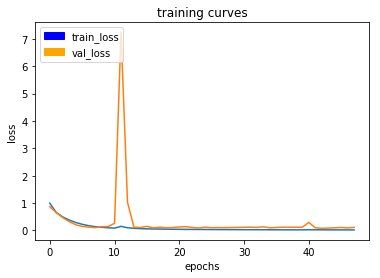

83/83 [==============================] - 185s - loss: 0.0179 - val_loss: 0.1108
Epoch 49/100
82/83 [============================>.] - ETA: 2s - loss: 0.0177

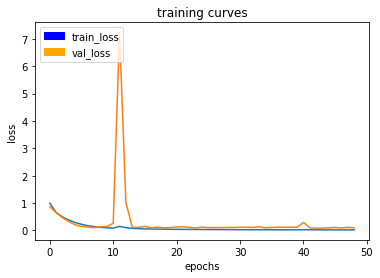

83/83 [==============================] - 185s - loss: 0.0177 - val_loss: 0.0916
Epoch 50/100
82/83 [============================>.] - ETA: 2s - loss: 0.0172

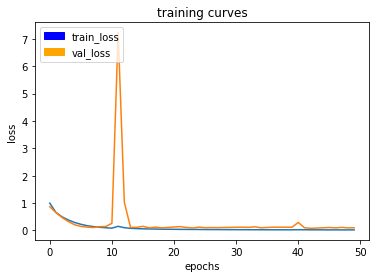

83/83 [==============================] - 185s - loss: 0.0172 - val_loss: 0.0961
Epoch 51/100
82/83 [============================>.] - ETA: 2s - loss: 0.0170

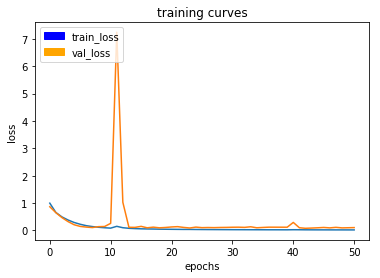

83/83 [==============================] - 185s - loss: 0.0170 - val_loss: 0.1019
Epoch 52/100
82/83 [============================>.] - ETA: 2s - loss: 0.0167

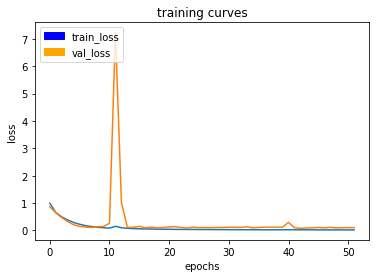

83/83 [==============================] - 185s - loss: 0.0166 - val_loss: 0.0992
Epoch 53/100
82/83 [============================>.] - ETA: 2s - loss: 0.0165

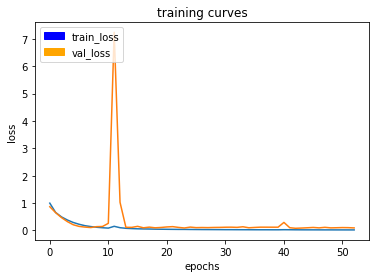

83/83 [==============================] - 185s - loss: 0.0165 - val_loss: 0.0897
Epoch 54/100
82/83 [============================>.] - ETA: 2s - loss: 0.0162

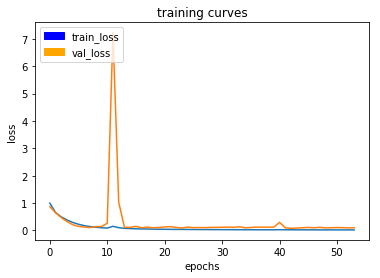

83/83 [==============================] - 185s - loss: 0.0162 - val_loss: 0.0960
Epoch 55/100
82/83 [============================>.] - ETA: 2s - loss: 0.0159

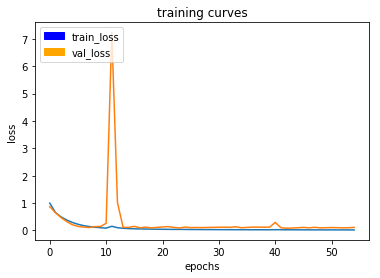

83/83 [==============================] - 185s - loss: 0.0160 - val_loss: 0.1080
Epoch 56/100
82/83 [============================>.] - ETA: 2s - loss: 0.0157

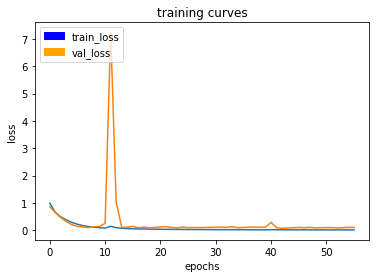

83/83 [==============================] - 185s - loss: 0.0157 - val_loss: 0.1071
Epoch 57/100
82/83 [============================>.] - ETA: 2s - loss: 0.0154

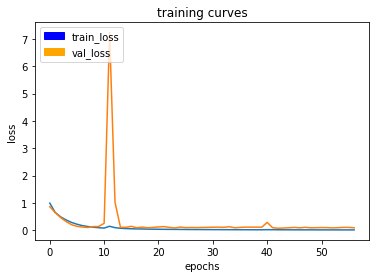

83/83 [==============================] - 185s - loss: 0.0153 - val_loss: 0.0937
Epoch 58/100
82/83 [============================>.] - ETA: 2s - loss: 0.0152

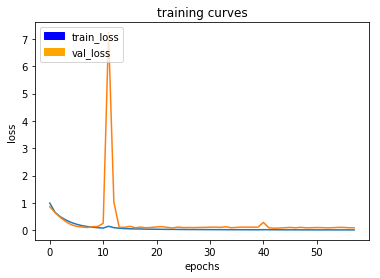

83/83 [==============================] - 184s - loss: 0.0152 - val_loss: 0.0926
Epoch 59/100
82/83 [============================>.] - ETA: 2s - loss: 0.0148

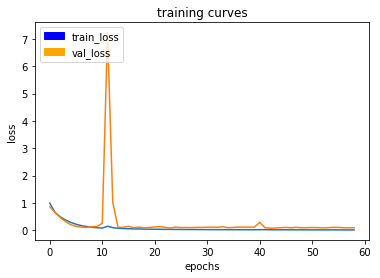

83/83 [==============================] - 185s - loss: 0.0148 - val_loss: 0.0939
Epoch 60/100
82/83 [============================>.] - ETA: 2s - loss: 0.0148

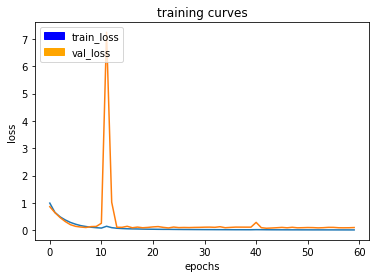

83/83 [==============================] - 185s - loss: 0.0148 - val_loss: 0.1016
Epoch 61/100
82/83 [============================>.] - ETA: 2s - loss: 0.0146

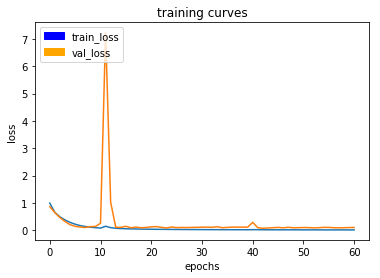

83/83 [==============================] - 185s - loss: 0.0146 - val_loss: 0.1027
Epoch 62/100
65/83 [======================>.......] - ETA: 38s - loss: 0.0143

ResourceExhaustedError: OOM when allocating tensor with shape[45,256,256,32]
	 [[Node: gradients_2/batch_normalization_16/moments/SquaredDifference_grad/sub = Sub[T=DT_FLOAT, _class=["loc:@batch_normalization_16/moments/SquaredDifference"], _device="/job:localhost/replica:0/task:0/gpu:0"](separable_conv2d_keras_15/Relu, batch_normalization_16/moments/StopGradient, ^gradients_2/batch_normalization_16/moments/variance_grad/truediv)]]

Caused by op 'gradients_2/batch_normalization_16/moments/SquaredDifference_grad/sub', defined at:
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-11271f818646>", line 29, in <module>
    workers = workers)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/engine/training.py", line 1750, in fit_generator
    self._make_train_function()
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/engine/training.py", line 926, in _make_train_function
    self._collected_trainable_weights, self.constraints, self.total_loss)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/optimizers.py", line 622, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/optimizers.py", line 95, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/backend.py", line 2453, in gradients
    loss, variables, colocate_gradients_with_ops=True)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py", line 838, in _SquaredDifferenceGrad
    x_grad = math_ops.scalar_mul(2.0, grad) * (x - y)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2629, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'batch_normalization_16/moments/SquaredDifference', defined at:
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-43d01d84764b>", line 11, in <module>
    output_layer = fcn_model(inputs, num_classes)
  File "<ipython-input-8-011f163d7b1c>", line 21, in fcn_model
    x1_p = decoder_block(x2_p, inputs, 32)
  File "<ipython-input-7-f89be441e369>", line 11, in decoder_block
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
  File "<ipython-input-2-40a7623c9d81>", line 5, in separable_conv2d_batchnorm
    output_layer = layers.BatchNormalization()(output_layer)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/engine/topology.py", line 396, in __call__
    output = super(Layer, self).__call__(inputs, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/contrib/keras/python/keras/layers/normalization.py", line 119, in call
    output = super(BatchNormalization, self).call(inputs, training=training)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/layers/normalization.py", line 370, in call
    mean, variance = nn.moments(inputs, reduction_axes)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 621, in moments
    math_ops.squared_difference(y, array_ops.stop_gradient(mean)),
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2610, in squared_difference
    result = _op_def_lib.apply_op("SquaredDifference", x=x, y=y, name=name)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/roy/anaconda3/envs/RoboND/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[45,256,256,32]
	 [[Node: gradients_2/batch_normalization_16/moments/SquaredDifference_grad/sub = Sub[T=DT_FLOAT, _class=["loc:@batch_normalization_16/moments/SquaredDifference"], _device="/job:localhost/replica:0/task:0/gpu:0"](separable_conv2d_keras_15/Relu, batch_normalization_16/moments/StopGradient, ^gradients_2/batch_normalization_16/moments/variance_grad/truediv)]]


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [17]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [18]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [19]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

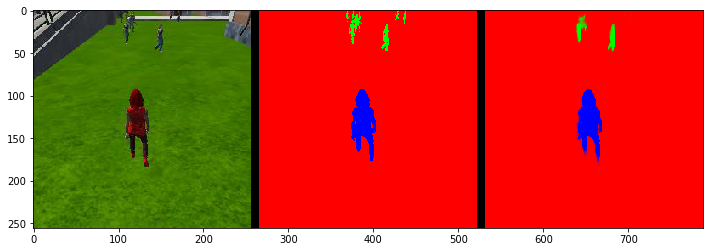

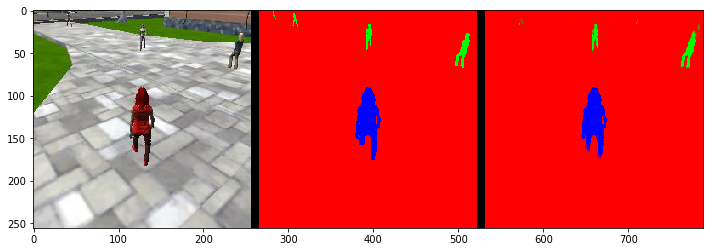

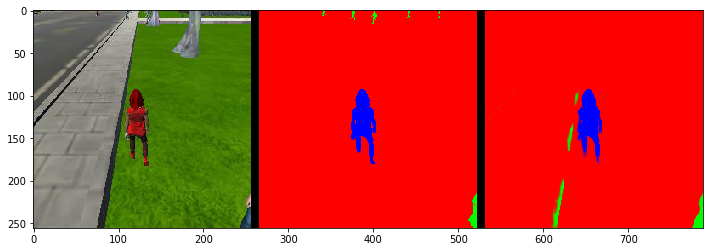

In [20]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

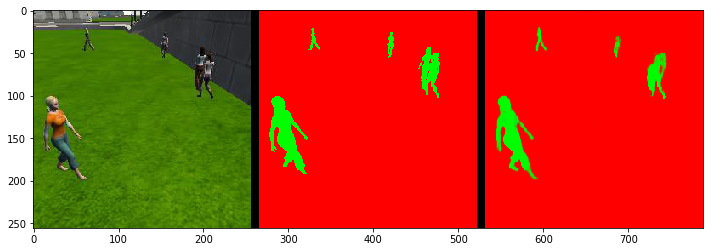

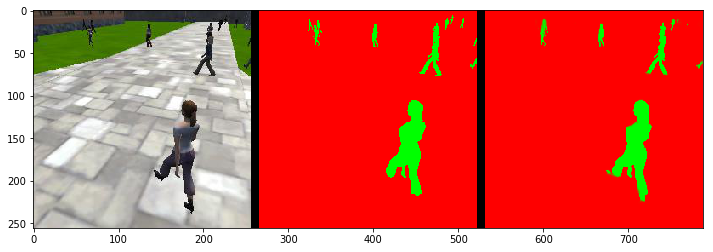

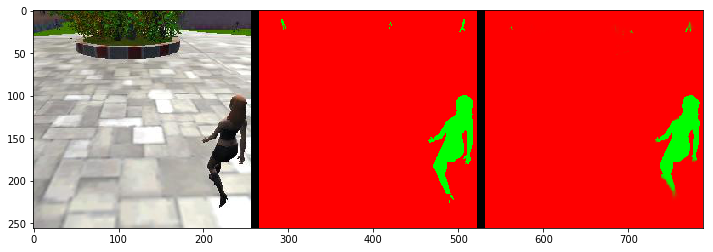

In [21]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

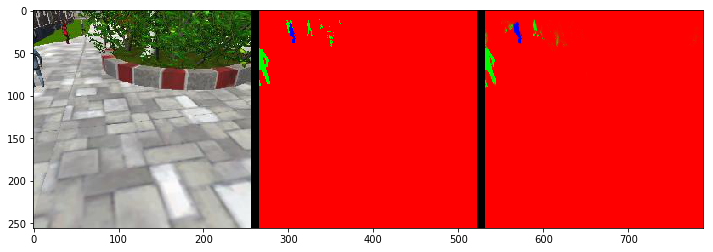

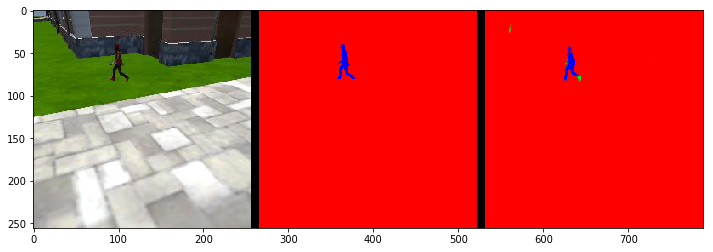

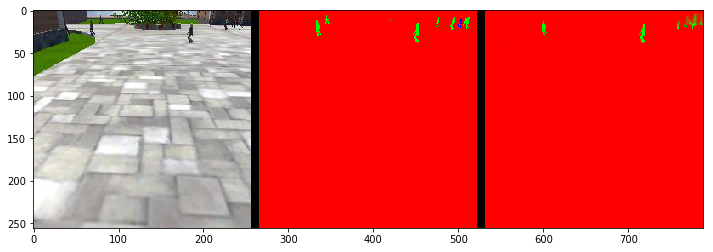

In [22]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [23]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9963566887214356
average intersection over union for other people is 0.3144992167908021
average intersection over union for the hero is 0.9384211940973574
number true positives: 539, number false positives: 0, number false negatives: 0


In [24]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.990061095024043
average intersection over union for other people is 0.7990635820483607
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 54, number false negatives: 0


In [25]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9971826973186233
average intersection over union for other people is 0.46948556855974
average intersection over union for the hero is 0.34822711005852264
number true positives: 165, number false positives: 2, number false negatives: 147


In [26]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7761852260198456


In [27]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.643324152078


In [28]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.499338702385
